In [1]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import clone_model

from dm_control import suite
from dm_control import viewer
import time
import random 

from matplotlib import pyplot as plt

In [2]:
def convert_observation(obs):
    list1 = [i.tolist() for i in list(obs.values())]
    list2 = np.array([])
    for sublist in list1:
        list2 = np.append(list2, sublist)
    return list2.reshape([1,25])

In [3]:
# parameters and models from : https://arxiv.org/pdf/1801.00690.pdf
# https://spinningup.openai.com/en/latest/algorithms/ddpg.html
# losses: https://books.google.ru/books?id=O0vODwAAQBAJ&pg=PA521&lpg=PA521&dq=ddpg+critic+loss&source=bl&ots=IpfwYeBefs&sig=ACfU3U1hyUgfCDUmU3SeIn5Nm4iNwnC8Ow&hl=ru&sa=X&ved=2ahUKEwjbxYOeqdLpAhWMtYsKHf_YCWsQ6AEwCXoECAoQAQ#v=onepage&q=ddpg%20critic%20loss&f=false

In [4]:
tf.keras.backend.set_floatx('float64')


class Agent:
    def __init__(self, action_spec):
        self.memory = {
            "state":np.array([]), 
            "action":np.array([], dtype = int), 
            "reward":np.array([]),
            "new_state":np.array([]), 
            "done":np.array([])
        }
        self.batch_size=64
        self.discount_rate=0.99
        self.tau=0.01
        self.action_dim = len(action_spec.minimum)
        self.action_spec = action_spec
        self.input_size = 25
        self.noise_scale = 1.0
        
        
        self.critic_opt = tf.optimizers.Adam(1e-3)
        self.actor_opt = tf.optimizers.Adam(1e-3)        

        # create critic model:      
        action_input = tf.keras.Input(shape=(self.action_dim,), name='action')
        observation_input = tf.keras.Input(shape=self.input_size, name='state')
        flattened_observation = tf.keras.layers.Flatten()(observation_input)
        x = tf.keras.layers.Dense(400)(flattened_observation)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Concatenate()([x, action_input])
        x = tf.keras.layers.Dense(300)(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Dense(1)(x)
        x = tf.keras.layers.Activation('linear')(x)
        critic = tf.keras.Model(inputs=[action_input, observation_input], outputs=x)
        self.critic_model = critic

        # create actor model:
        actor = tf.keras.Sequential()
        actor.add(tf.keras.layers.Input(shape = self.input_size, name='observation_input'))
        actor.add(tf.keras.layers.Dense(400))
        actor.add(tf.keras.layers.Activation('relu'))
        actor.add(tf.keras.layers.Dense(300))
        actor.add(tf.keras.layers.Activation('relu'))
        actor.add(tf.keras.layers.Dense(self.action_dim))
        actor.add(tf.keras.layers.Activation('tanh'))
        self.actor_model = actor

        # target models:
        self.target_critic_model = clone_model(self.critic_model)
        self.target_critic_model.compile(optimizer='sgd', loss='mse')
        
        self.target_actor_model = clone_model(self.actor_model)
        self.target_actor_model.compile(optimizer='sgd', loss='mse')
        
        self.actor_model.compile(optimizer='sgd', loss='mse')
        self.critic_model.compile(optimizer=self.critic_opt, loss='mse')
 
    def sample_action(self, obs):
        action = self.actor_model.predict(obs)[0]
        action = action + self.noise_scale*np.random.normal(0,1,size = self.action_dim)
        action = np.clip(action, -1.0, 1.0)
        return action
           
    
    def store_info(self, obs, new_obs, action, reward, done):
        if len(self.memory["state"])>0:
            if self.memory["done"].shape[0]>1e6:
                for key in self.memory.keys():
                    self.memory[key] = self.memory[key][-int(0.9e6):]
            self.memory["state"] = np.vstack((self.memory["state"], obs))
            self.memory["new_state"] = np.vstack((self.memory["new_state"], new_obs))
            self.memory["action"] = np.vstack((self.memory["action"], action))
        else:            
            self.memory["state"] = np.array(obs)
            self.memory["new_state"] = np.array(new_obs)
            self.memory["action"] = np.array(action)
        self.memory["reward"] = np.append(self.memory["reward"], reward)
        self.memory["done"] = np.append(self.memory["done"], done)        
        
        
    def experience_replay(self):
        if self.memory["done"].shape[0]>=self.batch_size:
            # get batch
            idxs = random.sample(range(0, self.memory["done"].shape[0]), self.batch_size)
            batch = {
                "state": np.squeeze(self.memory["state"][idxs]), 
                "action": np.squeeze(self.memory["action"][idxs]), 
                "reward": self.memory["reward"][idxs], 
                "new_state": np.squeeze(self.memory["new_state"][idxs]), 
                "done": self.memory["done"][idxs]
            }
            
            # replay:
            target_q = self.target_critic_model({"state":batch["new_state"], 
                                            "action": self.target_actor_model(batch["new_state"])})
                      
            y = batch["reward"].reshape(self.batch_size,1) + \
                (self.discount_rate*(1-batch["done"])).reshape(self.batch_size,1)*target_q
           
            # update critic

            self.critic_model.train_on_batch({"state": batch["state"], "action": batch["action"]}, y)

            # update actor policy
            with tf.GradientTape() as tape:
                q = self.critic_model({"state": batch["state"], 
                                       "action": self.actor_model(batch["state"])})
                actor_loss = - tf.reduce_mean(q)
            actor_grads = tape.gradient(actor_loss, self.actor_model.trainable_weights)
            self.actor_opt.apply_gradients(zip(actor_grads, self.actor_model.trainable_weights))

                        
            # update networks
            self.target_critic_model.set_weights((1.0-self.tau) * np.array(self.target_critic_model.get_weights()) + \
                                          self.tau*np.array(self.critic_model.get_weights()))
            self.target_actor_model.set_weights((1.0-self.tau) * np.array(self.target_actor_model.get_weights()) + \
                                         self.tau*np.array(self.actor_model.get_weights()))
            
            self.noise_scale*=0.99



In [5]:
def save_models(agent):
    agent.critic_model.save('critic_model_snake.h5')
    agent.actor_model.save('actor_model_snake.h5')
    agent.target_critic_model.save('target_critic_model_snake.h5')
    agent.target_actor_model.save('target_actor_model_snake.h5')
    
def train_model(env, n_iterations, batch_size, discount_rate):
    scores = np.array([])
    last_rewards = np.array([])
    first_rewards = np.array([])
    action_spec = env.action_spec()
    agent = Agent(action_spec)
    start = time.time()

    for iteration in range(1, n_iterations+1):       
        if (iteration % 25) == 0:
            save_models(agent)
            np.savetxt('scores.csv', scores, fmt='%1.2f')
            np.savetxt('last_rewards.csv', last_rewards, fmt='%1.2f')
            np.savetxt('first_rewards.csv', first_rewards, fmt='%1.2f')       
            print("{} iterations left".format(iteration))
            print("{:10.3f} minutes remaining".format((time.time()-start)/60))
            
        if (iteration % 100) == 0:
            plt.figure(figsize=(15,7))
            plt.grid()
            x=list(range(len(scores)))
            plt.plot(x, scores)

            plt.title("Learning curves: score per iteration")
            plt.ylabel("Reward")
            plt.xlabel("Iteration number")
            plt.show()

        time_step = env.reset()  
        obs = convert_observation(time_step.observation)

        game_score = 0
        while not time_step.last():       
            # get action:
            action = agent.sample_action(obs)
            # make action:
            time_step = env.step(action)
            new_obs = convert_observation(time_step.observation)            
            # update history:
            game_score += time_step.reward 
            agent.store_info(obs, new_obs, action, time_step.reward, 0)
            obs = new_obs
            # experience replay:
            agent.experience_replay()

            if len(first_rewards)==len(last_rewards):
                first_rewards = np.append(first_rewards, time_step.reward)

        new_obs = convert_observation(time_step.observation)   
        agent.store_info(obs, new_obs, action, time_step.reward, 1)
        agent.experience_replay()

        game_score += time_step.reward 
        
        scores = np.append(scores, game_score)
        last_rewards = np.append(last_rewards, time_step.reward)
        #print("Iteration: {};   score: {:10.3f}; last_reward: {:10.3f}; first_reward: {:10.3f}".format(
        #    iteration, game_score, time_step.reward, first_rewards[-1]))

    save_models(agent)
    np.savetxt('scores.csv', scores, fmt='%1.2f')
    np.savetxt('last_rewards.csv', last_rewards, fmt='%1.2f')
    np.savetxt('first_rewards.csv', first_rewards, fmt='%1.2f')
    return scores, last_rewards, first_rewards, agent


25 iterations left
    24.755 minutes remaining
50 iterations left
    53.510 minutes remaining
75 iterations left
    85.208 minutes remaining
100 iterations left
   119.869 minutes remaining


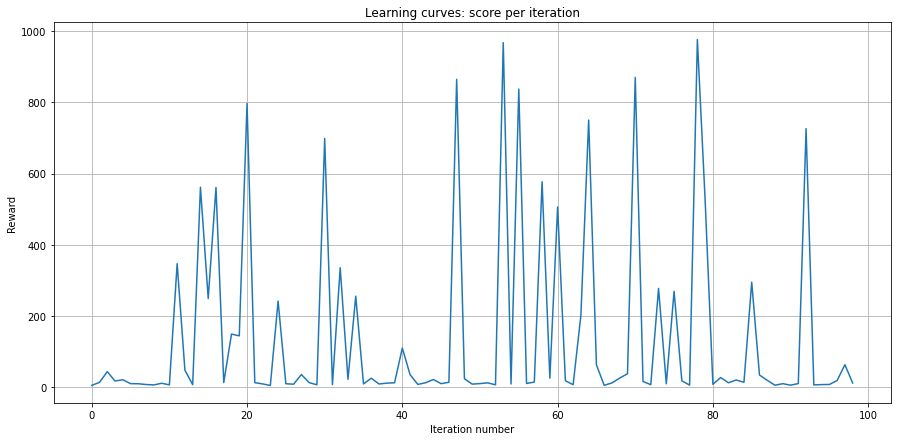

125 iterations left
   157.808 minutes remaining
150 iterations left
   198.963 minutes remaining
175 iterations left
   243.065 minutes remaining
200 iterations left
   290.438 minutes remaining


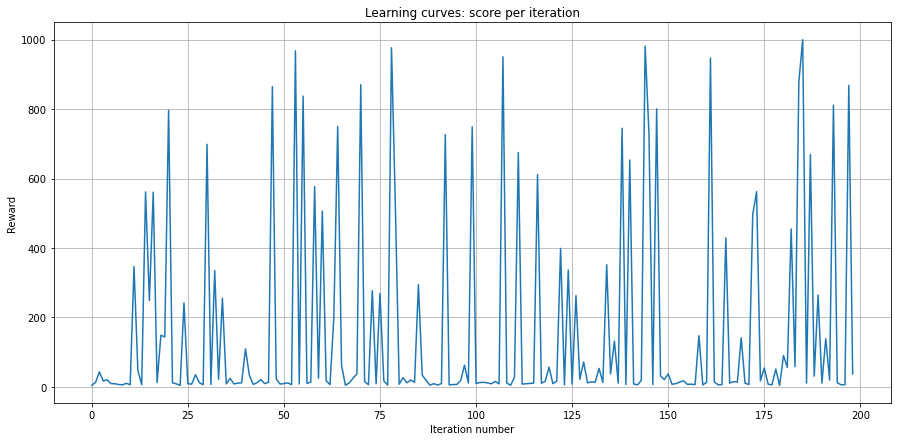

225 iterations left
   373.230 minutes remaining
250 iterations left
   443.698 minutes remaining
275 iterations left
   507.483 minutes remaining
300 iterations left
   574.455 minutes remaining


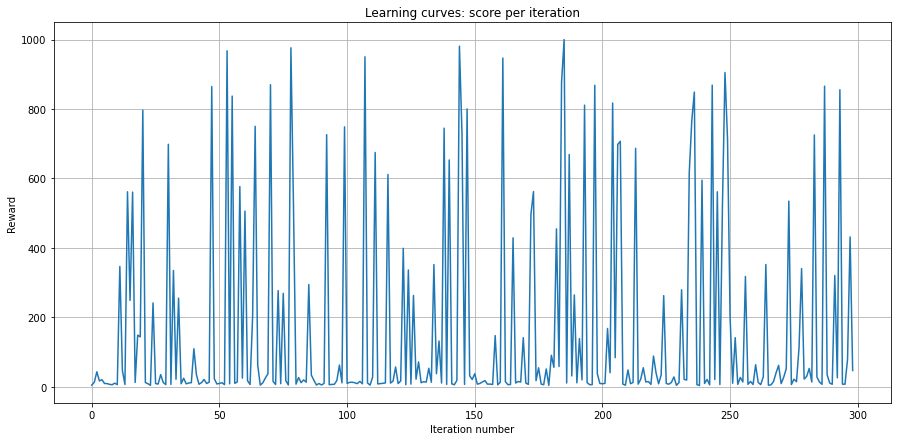

325 iterations left
   644.026 minutes remaining
350 iterations left
   713.604 minutes remaining
375 iterations left
   781.332 minutes remaining
400 iterations left
   852.050 minutes remaining


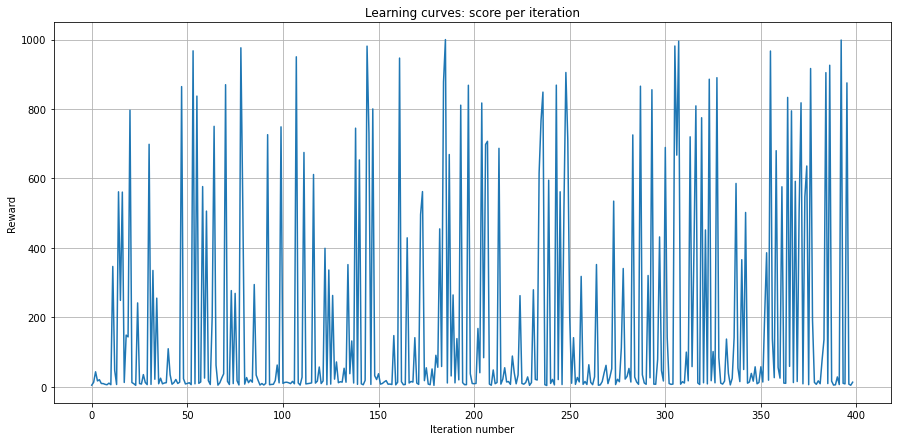

425 iterations left
   926.281 minutes remaining
450 iterations left
  1002.715 minutes remaining
475 iterations left
  1082.380 minutes remaining
500 iterations left
  1165.276 minutes remaining


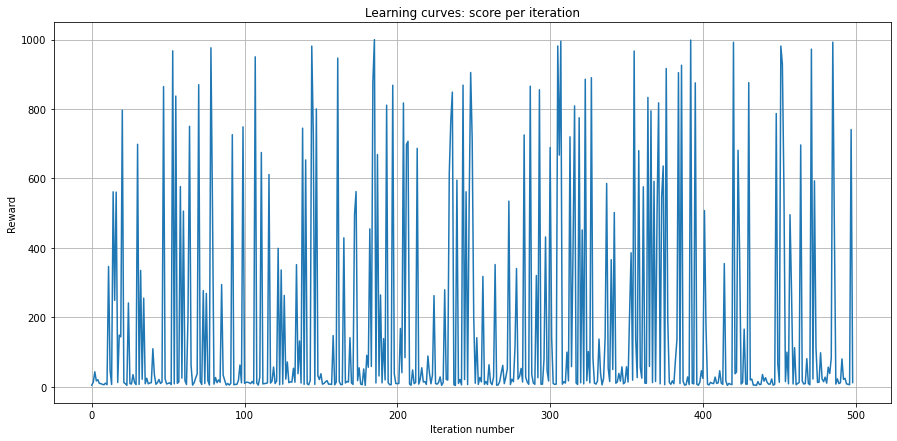

In [6]:
n_iterations = 500
env = suite.load(domain_name="swimmer", task_name="swimmer6")
action_spec = env.action_spec()

scores, last_rewards, first_rewards, agent = train_model(env, n_iterations, batch_size=64, discount_rate=0.99)

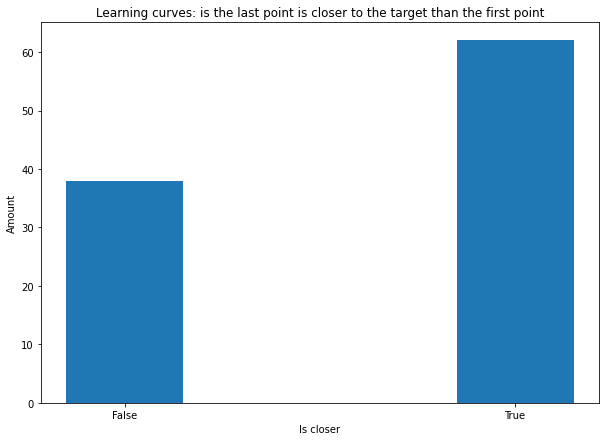

In [7]:
better_arr = np.array((last_rewards[-100:] - first_rewards[-100:])>0, dtype = int)
plt.figure(figsize=(10,7))
better_results = np.sum(better_arr)
plt.bar([0, 1],[len(better_arr)-better_results, better_results], 0.3)
plt.xticks([0,1],labels = ["False", "True"])
plt.title("Learning curves: is the last point is closer to the target than the first point")
plt.ylabel("Amount")
plt.xlabel("Is closer")
plt.savefig("closer_points.png")
plt.show()

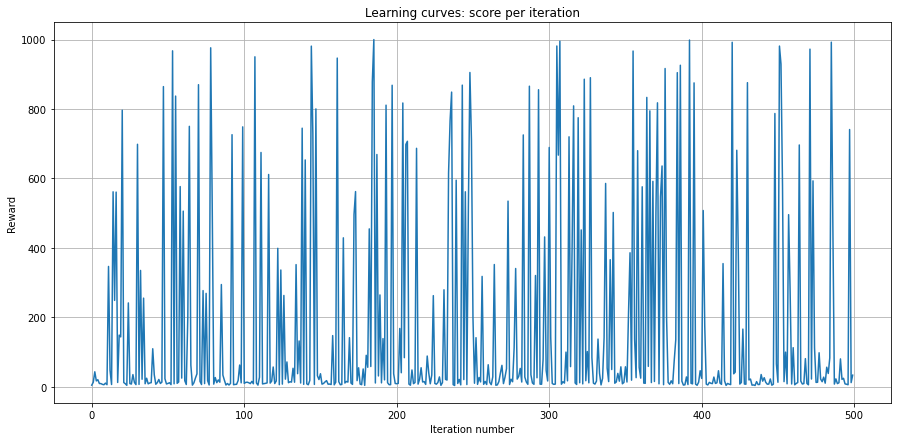

In [8]:
plt.figure(figsize=(15,7))
plt.grid()
x=list(range(len(scores)))
plt.plot(x, scores)

plt.title("Learning curves: score per iteration")
plt.ylabel("Reward")
plt.xlabel("Iteration number")
plt.savefig("learning_curves.png")
plt.show()

In [23]:
def stats(step, scores, last_rewards, first_rewards):
    amount = int(500/step)+1
    means = []
    mins = []
    quantiles = []
    less_50 = []
    less_100 = []
    less_250 = []
    less_500 = []
    less_750 = []

    first_reward_less_025 = []
    last_reward_less_025 = []
    first_reward_less_05 = []
    last_reward_less_05 = []
    first_reward_less_075 = []
    last_reward_less_075 = []

    is_better = []
    for i in range(1,amount):
        means.append(np.mean(scores[(i-1)*step: i*step]))
        mins.append(np.min(scores[(i-1)*step: i*step]))
        quantiles.append(np.quantile(scores[(i-1)*step: i*step], 0.25))

        less_50.append(np.sum(np.array(scores[(i-1)*step: i*step]<50, dtype = int)))
        less_100.append(np.sum(np.array(scores[(i-1)*step: i*step]<100, dtype = int)))
        less_250.append(np.sum(np.array(scores[(i-1)*step: i*step]<250, dtype = int)))
        less_500.append(np.sum(np.array(scores[(i-1)*step: i*step]<500, dtype = int)))
        less_750.append(np.sum(np.array(scores[(i-1)*step: i*step]<750, dtype = int)))

        is_better.append(np.sum(np.array((last_rewards[(i-1)*step: i*step] - \
                                                      first_rewards[(i-1)*step: i*step])>0, dtype = int)))

        first_reward_less_025.append(np.sum(np.array(first_rewards[(i-1)*step: i*step]<0.25, dtype = int)))
        first_reward_less_05.append(np.sum(np.array(first_rewards[(i-1)*step: i*step]<0.5, dtype = int)))
        first_reward_less_075.append(np.sum(np.array(first_rewards[(i-1)*step: i*step]<0.75, dtype = int)))

        last_reward_less_025.append(np.sum(np.array(last_rewards[(i-1)*step: i*step]<0.25, dtype = int)))
        last_reward_less_05.append(np.sum(np.array(last_rewards[(i-1)*step: i*step]<0.5, dtype = int)))
        last_reward_less_075.append(np.sum(np.array(last_rewards[(i-1)*step: i*step]<0.75, dtype = int)))

    print(" Подсчет величин осуществляется на каждых {} итерациях обучения".format(step))
    print("Среднее значение суммарной награды: ", means)
    print("Минимальное значение суммарной награды: ", mins)
    print("Первый квартиль суммарной награды: ", quantiles)
    print()
    print("Количество суммарной награды меньше 50: ", less_50)
    print("Количество суммарной награды меньше 100: ", less_100)
    print("Количество суммарной награды меньше 250: ", less_250)
    print("Количество суммарной награды меньше 500: ", less_500)
    print("Количество суммарной награды меньше 750: ", less_750)
    print()
    print("Количество итераций, на которых в конце игры змейка оказалась ближе к точке, чем в начале: ", is_better)
    print()
    print("Количество итераций, где первая награда меньше 0.25: ", first_reward_less_025)
    print("Количество итераций, где последняя награда меньше 0.25: ", last_reward_less_025)
    print("Количество итераций, где первая награда меньше 0.5: ", first_reward_less_05)
    print("Количество итераций, где последняя награда меньше 0.5: ", last_reward_less_05)
    print("Количество итераций, где первая награда меньше 0.75: ", first_reward_less_075)
    print("Количество итераций, где последняя награда меньше 0.75: ", last_reward_less_075)

In [24]:
stats(100, scores, last_rewards, first_rewards)

 Подсчет величин осуществляется на каждых 100 итерациях обучения
Среднее значение суммарной награды:  [149.55453873494568, 167.8251505443352, 167.83859459399545, 242.37596949560088, 144.64389260971922]
Минимальное значение суммарной награды:  [4.379743194068595, 4.182794752730698, 3.8107508009329294, 4.515236991421478, 3.903962004194696]
Первый квартиль суммарной награды:  [8.924308980951018, 9.59495298925607, 9.592498156395504, 10.840656379541835, 8.373211049794508]

Количество суммарной награды меньше 50:  [71, 65, 64, 53, 71]
Количество суммарной награды меньше 100:  [73, 73, 72, 62, 78]
Количество суммарной награды меньше 250:  [79, 77, 76, 70, 82]
Количество суммарной награды меньше 500:  [85, 85, 83, 74, 87]
Количество суммарной награды меньше 750:  [93, 92, 93, 85, 93]

Количество итераций, на которых в конце игры змейка оказалась ближе к точке, чем в начале:  [51, 60, 51, 62, 62]

Количество итераций, где первая награда меньше 0.25:  [77, 79, 78, 70, 83]
Количество итераций, гд

In [25]:
stats(50, scores, last_rewards, first_rewards)

 Подсчет величин осуществляется на каждых 50 итерациях обучения
Среднее значение суммарной награды:  [116.95270173232691, 182.1563757375644, 165.32773944964794, 170.32256163902258, 214.41352826734246, 121.26366092064842, 220.03848266964684, 264.713456321555, 111.27852449085972, 178.00926072857877]
Минимальное значение суммарной награды:  [4.379743194068595, 4.930741598207328, 5.00547704094732, 4.182794752730698, 3.8107508009329294, 4.605035553286508, 5.5958449944363835, 4.515236991421478, 3.903962004194696, 5.91281065381907]
Первый квартиль суммарной награды:  [8.86301163644626, 9.319861260374386, 9.942854607352084, 8.360297751439928, 9.182139179103908, 10.50644514641496, 11.19145314376738, 10.34699829398064, 7.617306353363253, 9.934185510385943]

Количество суммарной награды меньше 50:  [37, 34, 34, 31, 31, 33, 27, 26, 40, 31]
Количество суммарной награды меньше 100:  [37, 36, 37, 36, 34, 38, 32, 30, 41, 37]
Количество суммарной награды меньше 250:  [42, 37, 38, 39, 35, 41, 36, 34, 43

Average reward on test 100 games:  233.5883165207959


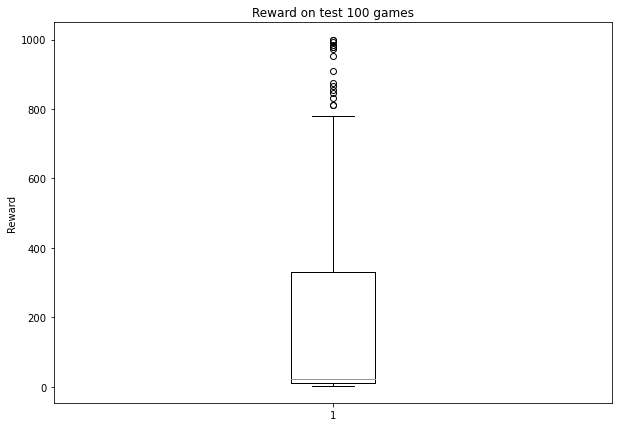

In [10]:
test_games = 100

test_scores = []
test_last_rewards = []
for game_index in range(test_games):
    score = 0
    time_step = env.reset()  
    obs = convert_observation(time_step.observation)
    while not time_step.last(): 
        action = agent.target_actor_model.predict(obs)
        time_step = env.step(action[0])
        obs = convert_observation(time_step.observation)
        score += time_step.reward

    test_scores.append(score)
    test_last_rewards.append(time_step.reward)

print("Average reward on test 100 games: ", np.mean(test_scores))

fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Reward on test 100 games')
ax.boxplot(test_scores,   
          showfliers=True)

ax.set_ylabel("Reward")
plt.savefig("rewards.png")
plt.show()

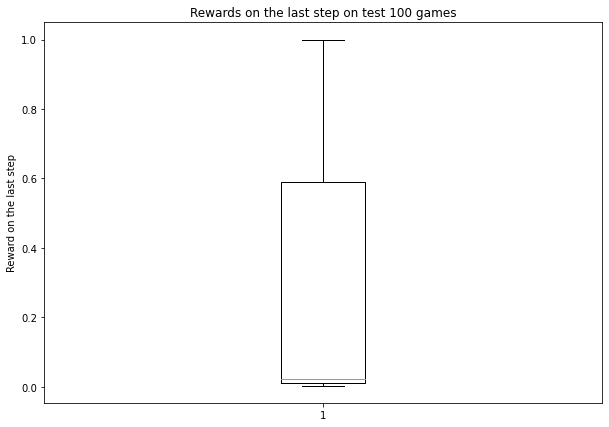

In [11]:
fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Rewards on the last step on test 100 games')
ax.boxplot(test_last_rewards,   
          showfliers=True)

ax.set_ylabel("Reward on the last step")
plt.savefig("last_rewards.png")
plt.show()